In [1]:
from rmgpy import settings
from rmgpy.data.rmg import RMGDatabase, database
from rmgpy.rmg.main import RMG
from rmgpy.rmg.model import Species
from rmgpy.data.thermo import *
from rmgpy.molecule.molecule import Molecule
import rmgpy
import rmgpy.molecule.element as elements
from IPython.display import display

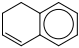

atom C:
valence_electron: 4, order: 4.0, charge: 0
atom C:
valence_electron: 4, order: 4.0, charge: 0
atom C:
valence_electron: 4, order: 3.0, charge: 1
atom C:
valence_electron: 4, order: 3.0, charge: 1
atom C:
valence_electron: 4, order: 2.0, charge: 2
atom C:
valence_electron: 4, order: 3.0, charge: 1
atom C:
valence_electron: 4, order: 3.0, charge: 1
atom C:
valence_electron: 4, order: 2.0, charge: 2
atom C:
valence_electron: 4, order: 3.0, charge: 1
atom C:
valence_electron: 4, order: 3.0, charge: 1


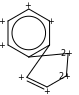

In [2]:
smiles = 'C1C=C2C=CC=C3C=CC4=CC=CC=1C4=C23'
spe = Species().fromSMILES(smiles)
spe.generateResonanceIsomers()

spe.molecule[0].update()


for mol in spe.molecule:
    sssr0 = mol.getSmallestSetOfSmallestRings()
    aromaticRingNum = 0
    for sr0 in sssr0:
        sr0mol = Molecule(atoms=sr0)
        if isAromaticRing(sr0mol):
            aromaticRingNum += 1
    if aromaticRingNum == 2:
        break

polyring = mol.getDisparateRings()[1][0]


if True:
    submol, _ = convertRingToSubMolecule(polyring)
    SSSR = submol.getDeterministicSmallestSetOfSmallestRings()

    ringPairWithCommonAtomsList = []
    ringOccurancesDict = {}
    
    # Initialize ringOccuranceDict
    for ring in SSSR:
        ringOccurancesDict[tuple(ring)] = 0

    ringNum = len(SSSR)
    for i in range(ringNum):
        for j in range(i+1,ringNum):
            if commonAtoms(SSSR[i], SSSR[j]):
                # Copy the SSSR's again because these ones are going to be merged into bicyclics
                # and manipulated (aromatic bonds have to be screened and changed to single if needed)
                SSSRi, SSSRj, mergedRing = getCopyFromTwoRingsWithCommonAtoms(SSSR[i], SSSR[j])
                ringPairWithCommonAtomsList.append([SSSRi, SSSRj, mergedRing])
                # Save the single ring SSSRs that appear in bicyclics using the original copy
                # because they will be manipulated (differently) in __addPolyRingCorrectionThermoDataFromHeuristic
                ringOccurancesDict[tuple(SSSR[i])] += 1
                ringOccurancesDict[tuple(SSSR[j])] += 1

    bicyclicsMergedFromRingPair = []
    # pre-process 2-ring cores
    for ringA, ringB, mergedRing in ringPairWithCommonAtomsList:
        submolA = Molecule(atoms=ringA)
        submolB = Molecule(atoms=ringB)
        isA_aromatic = isAromaticRing(submolA)
        isB_aromatic = isAromaticRing(submolB)
        # if ringA and ringB are both aromatic or not aromatic
        # don't need to do anything extra
        if (isA_aromatic and isB_aromatic):
            pass
        elif (not isA_aromatic and not isB_aromatic):
            aromaticBonds_inA = findAromaticBondsFromSubMolecule(submolA)
            for aromaticBond_inA in aromaticBonds_inA:
                aromaticBond_inA.setOrderNum(1)

            aromaticBonds_inB = findAromaticBondsFromSubMolecule(submolB)
            for aromaticBond_inB in aromaticBonds_inB:
                aromaticBond_inB.setOrderNum(1)
        elif isA_aromatic:
            aromaticBonds_inB = findAromaticBondsFromSubMolecule(submolB)
            for aromaticBond_inB in aromaticBonds_inB:
                # Make sure the aromatic bond in ringB is in ringA, and both ringB atoms are in ringA 
                # If so, preserve the B bond status, otherwise change to single bond order
                if (aromaticBond_inB.atom1 in submolA.atoms) and (aromaticBond_inB.atom2 in submolA.atoms) and (submolA.hasBond(aromaticBond_inB.atom1, aromaticBond_inB.atom2)):
                    pass
                else:
                    aromaticBond_inB.setOrderNum(1)
        else:
            aromaticBonds_inA = findAromaticBondsFromSubMolecule(submolA)
            for aromaticBond_inA in aromaticBonds_inA:
                if (aromaticBond_inA.atom1 in submolB.atoms) and (aromaticBond_inA.atom2 in submolB.atoms) and (submolB.hasBond(aromaticBond_inA.atom1, aromaticBond_inA.atom2)):
                    pass
                else:
                    aromaticBond_inA.setOrderNum(1)
    #    mergedRing.update()#
     #   bicyclicsMergedFromRingPair.append(mergedRing)

display(mergedRing)
        
for atom in mergedRing.atoms:
    print "atom {0}:".format(atom)
    valence_electron = elements.PeriodicSystem.valence_electrons[atom.symbol]
    order = atom.getBondOrdersForAtom()
    atom.charge = valence_electron - order - atom.radicalElectrons - 2*atom.lonePairs
    print "valence_electron: {0}, order: {1}, charge: {2}".format(valence_electron,order,atom.charge)
    
display(mergedRing)

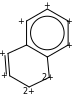

In [26]:
mergedRing

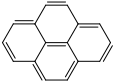

In [17]:
spe